In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
warnings.filterwarnings('ignore')

In [80]:
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')
sample_submission = pd.read_csv('./data/SampleSubmission.csv')

In [82]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [83]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [84]:
sample_submission.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [ ]:
train['Policy Duration'] = (train['Policy End Date'] - train['Policy Start Date']).dt.days
train['Customer Tenure'] = (train['Policy Start Date'] - train['First Transaction Date']).dt.days
test['Policy Duration'] = (test['Policy End Date'] - test['Policy Start Date']).dt.days
test['Customer Tenure'] = (test['Policy Start Date'] - test['First Transaction Date']).dt.days

today = pd.Timestamp.today()
train['Recency'] = (today - train['Policy End Date']).dt.days
test['Recency'] = (today - test['Policy End Date']).dt.days

In [ ]:
categorical_columns = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']
for col in categorical_columns:
    mode_value = train[col].mode()[0]
    train[col].fillna(mode_value, inplace=True)
    test[col].fillna(mode_value, inplace=True)

/var/folders/0n/p9ms0b591cg7_09nh12318dr0000gn/T/ipykernel_70584/2145228135.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(mode_value, inplace=True)
/var/folders/0n/p9ms0b591cg7_09nh12318dr0000gn/T/ipykernel_70584/2145228135.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [88]:
def clean_age(age):
    if age < 0 or age > 100:
        return np.nan  
    return age

In [89]:
max = train['Age'].min()
max

-6099

In [90]:
train['Age'] = train['Age'].apply(clean_age)
test['Age'] = test['Age'].apply(clean_age)


age_median = train['Age'].mean()
train['Age'].fillna(age_median, inplace=True)
test['Age'].fillna(age_median, inplace=True)

/var/folders/0n/p9ms0b591cg7_09nh12318dr0000gn/T/ipykernel_70584/319475849.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(age_median, inplace=True)
/var/folders/0n/p9ms0b591cg7_09nh12318dr0000gn/T/ipykernel_70584/319475849.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [ ]:

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = encoder.fit_transform(train[categorical_columns])
encoded_test = encoder.transform(test[categorical_columns])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

train = train.drop(columns=categorical_columns).reset_index(drop=True)
test = test.drop(columns=categorical_columns).reset_index(drop=True)

train = pd.concat([train, encoded_train_df], axis=1)
test = pd.concat([test, encoded_test_df], axis=1)

In [ ]:
X = train.drop(columns=['ID', 'target', 'Policy Start Date', 'Policy End Date', 'First Transaction Date'])
y = train['target']
X_test = test.drop(columns=['ID', 'Policy Start Date', 'Policy End Date', 'First Transaction Date'])

In [94]:
scaler = StandardScaler()
numerical_columns = ['Age', 'No_Pol', 'Policy Duration', 'Customer Tenure', 'Recency']
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [95]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
train_predictions = model.predict(X)

f1 = f1_score(y, train_predictions)
precision = precision_score(y, train_predictions)
recall = recall_score(y, train_predictions)
conf_matrix = confusion_matrix(y, train_predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

F1 Score: 0.7616
Precision: 0.8425
Recall: 0.6948
Confusion Matrix:
[[10435   189]
 [  444  1011]]


In [107]:
test_predictions = model.predict(X_test)

In [108]:
sample_submission['target'] = test_predictions
sample_submission.to_csv('submission.csv', index=False)

Loading data...
The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)
The shape of the combined dataframe is: (13281, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   objec

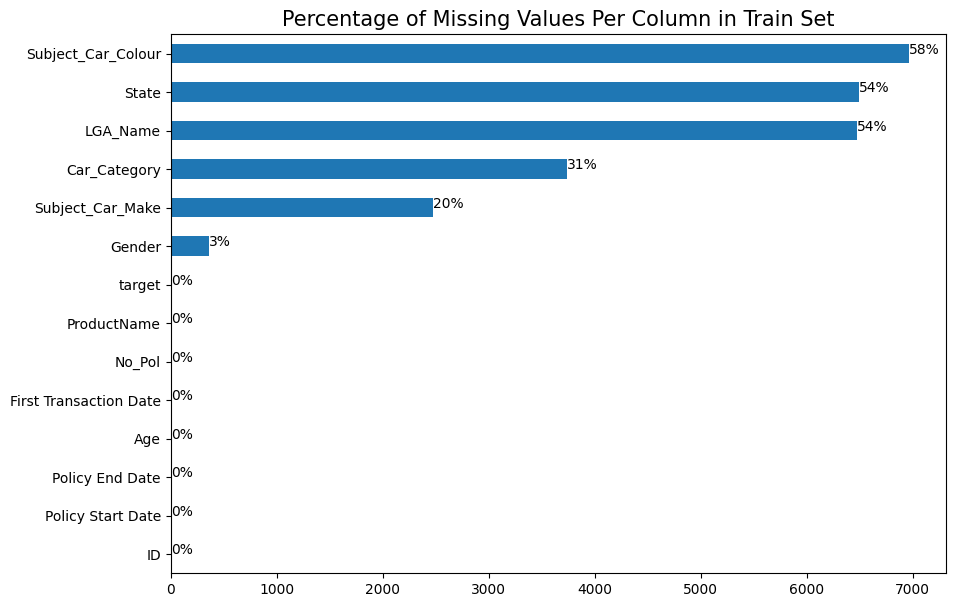

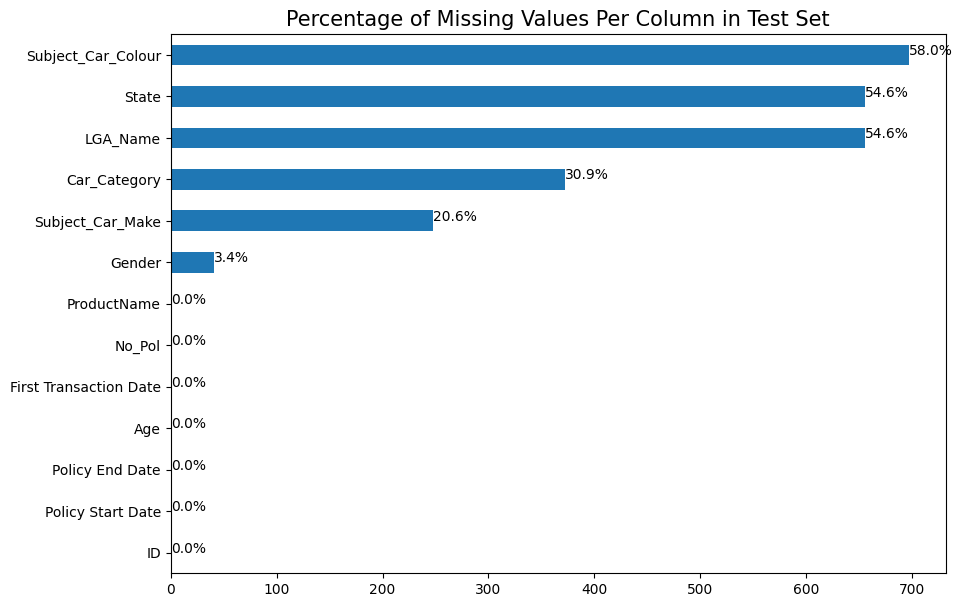

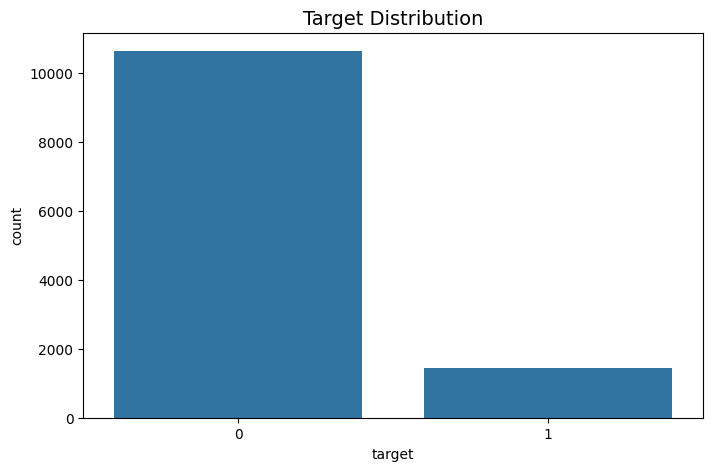

Gender distribution after mapping:
Gender
Male       8356
Female     3679
Other       580
Unknown     266
Name: count, dtype: int64

Performing feature engineering...

Missing values after imputation:
Age_Group    436
dtype: int64
Train shape after preprocessing: (12079, 572)
Test shape after preprocessing: (1202, 572)

Training LightGBM model...


[LightGBM] [Fatal] Do not support special JSON characters in feature name.


LightGBMError: Do not support special JSON characters in feature name.

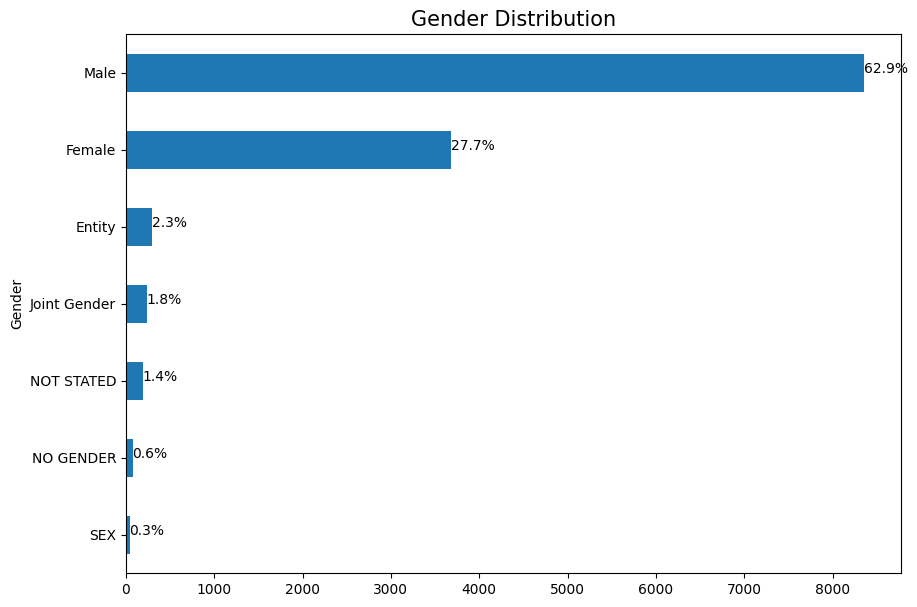

In [1]:
# AutoInland Vehicle Insurance Claim Challenge - Combined Notebook



### Importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For metrics and modeling
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models from starter notebook
from lightgbm import LGBMClassifier

# Additional models from your work
from sklearn.ensemble import RandomForestClassifier

### Read files
# Load files into a pandas dataframe
print("Loading data...")
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')
ss = pd.read_csv('./data/SampleSubmission.csv')

### Some basic EDA
# Preview the data
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

# Check if there are any missing values in train set
plt.figure(figsize=(10, 7))
ax = train.isna().sum().sort_values().plot(kind='barh')
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage = '{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x,y))

# Check if there are missing values in test set
plt.figure(figsize=(10, 7))
ax = test.isna().sum().sort_values().plot(kind='barh')
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})
for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

# Check the column names and datatypes
all_data.info()

# Change each column to its appropriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
    if col in date_cols:
        all_data[col] = pd.to_datetime(all_data[col])
    elif col in cat_cols:
        all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

### Distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x=train.target)
plt.title('Target Distribution', fontdict={'size':14})
plt.show()

### Distribution of categorical variables
# Gender distribution 
plt.figure(figsize=(10, 7))
ax = all_data.Gender.value_counts().sort_values().plot(kind='barh')
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x,y))

# Clean up the Gender column with mapping (from your code and starter code)
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Unknown', 'NO GENDER': 'Unknown', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
print("Gender distribution after mapping:")
print(all_data.Gender.value_counts())

### Feature Engineering from your work
print("\nPerforming feature engineering...")

# Calculate policy duration in days (from your code)
all_data['Policy Duration'] = (all_data['Policy End Date'] - all_data['Policy Start Date']).dt.days

# Calculate customer tenure (from your code)
all_data['Customer Tenure'] = (all_data['Policy Start Date'] - all_data['First Transaction Date']).dt.days

# Calculate recency (from your code)
today = pd.Timestamp.today()
all_data['Recency'] = (today - all_data['Policy End Date']).dt.days

# Additional date features (from starter code)
for col in date_cols:
    for date_feature in ['year', 'month', 'day']:
        all_data[col + '_' + date_feature] = getattr(all_data[col].dt, date_feature)
    
    # Additional date features (weekday, quarter, weekend)
    all_data[f'{col}_dayofweek'] = all_data[col].dt.dayofweek
    all_data[f'{col}_quarter'] = all_data[col].dt.quarter
    all_data[f'{col}_is_weekend'] = all_data[col].dt.dayofweek.isin([5, 6]).astype(int)

# Clean up Age column (from your code)
def clean_age(age):
    if pd.isna(age) or age < 0 or age > 100:
        return np.nan  
    return age

all_data['Age'] = all_data['Age'].apply(clean_age)

# Create age groups
all_data['Age_Group'] = pd.cut(all_data['Age'], 
                               bins=[0, 25, 35, 45, 55, 65, 100], 
                               labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])

# Create No_Pol groups
all_data['No_Pol_Group'] = pd.cut(all_data['No_Pol'], 
                                  bins=[0, 1, 3, 5, 10, float('inf')], 
                                  labels=['Single', '2-3', '4-5', '6-10', '10+'])

### Filling in missing values
# For numerical columns use median
for col in all_data.columns:
    if col in num_cols or col == 'Policy Duration' or col == 'Customer Tenure' or col == 'Recency':
        if all_data[col].isnull().any():
            med_val = all_data[col].median()
            all_data[col] = all_data[col].fillna(med_val)

# For categorical columns use mode
for col in cat_cols:
    if all_data[col].isnull().any():
        mode_val = all_data[col].mode()[0]
        all_data[col] = all_data[col].fillna(mode_val)

# Confirm that there aren't any missing values
missing_values = all_data[all_data.columns.difference(['target'])].isna().sum()
print("\nMissing values after imputation:")
print(missing_values[missing_values > 0])

### Update categorical columns list to include new categorical features
cat_cols = cat_cols + ['Age_Group', 'No_Pol_Group']

### Encoding categorical features
# One-hot encoding from starter notebook
all_data = pd.get_dummies(data=all_data, columns=cat_cols)

### Separate train and test data from the combined dataframe
# Update columns to exclude
exclude_cols = date_cols + ['ID', 'target']
main_cols = all_data.columns.difference(exclude_cols)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
print(f"Train shape after preprocessing: {train_df.shape}")
print(f"Test shape after preprocessing: {test_df.shape}")

### Model Training
# Select features and target
X = train_df[main_cols]
y = train_df.target
X_test = test_df[main_cols]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
num_features = ['Age', 'No_Pol', 'Policy Duration', 'Customer Tenure', 'Recency'] + \
               [col for col in X.columns if any(x in col for x in ['_year', '_month', '_day', '_dayofweek', '_quarter', '_is_weekend'])]

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Function to evaluate and print model metrics
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    
    # Print metrics
    print(f"\n{model_name} Metrics:")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    
    # Print confusion matrix
    print("Confusion Matrix on Validation Set:")
    print(confusion_matrix(y_val, y_val_pred))
    
    return model, val_f1

# Train and evaluate the LightGBM model (from starter notebook)
print("\nTraining LightGBM model...")
lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced'
)
lgbm_model, lgbm_val_f1 = evaluate_model(lgbm_model, X_train, y_train, X_val, y_val, "LightGBM")

# Train and evaluate Random Forest (from your code)
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
rf_model, rf_val_f1 = evaluate_model(rf_model, X_train, y_train, X_val, y_val, "Random Forest")

# Select the best model based on validation F1 score
if lgbm_val_f1 >= rf_val_f1:
    best_model = lgbm_model
    best_model_name = "LightGBM"
else:
    best_model = rf_model
    best_model_name = "Random Forest"

print(f"\nBest model: {best_model_name} with validation F1 score: {max(lgbm_val_f1, rf_val_f1):.4f}")

# Feature importance for the best model
if best_model_name == "LightGBM":
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Features by Importance ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\nTop 20 features by importance:")
    print(feature_importance.head(20))

elif best_model_name == "Random Forest":
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Features by Importance ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\nTop 20 features by importance:")
    print(feature_importance.head(20))

### Generate predictions with the best model
# Final prediction on test set
test_predictions = best_model.predict(X_test)

# Create submission file
submission = ss.copy()
submission['predictions'] = test_predictions

# Check the distribution of predictions
plt.figure(figsize=(8, 5))
sns.countplot(x=submission.predictions)
plt.title('Distribution of Predictions')
plt.show()

# Save submission file
submission.to_csv('combined_submission.csv', index=False)
print("\nSubmission file created: combined_submission.csv")

print("\nAdditional improvement ideas for future iterations:")
print("1. Try ensemble models combining LightGBM and Random Forest")
print("2. Apply SMOTE or other resampling techniques for class imbalance")
print("3. Implement cross-validation for more robust model evaluation")
print("4. Add interaction features between important categorical variables")
print("5. Try different hyperparameter tuning with GridSearchCV or Bayesian optimization")